In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import torch.optim as optim
from torch.utils.data import DataLoader

from score_models.models.mlp import MLPScoreModel
from score_models.trainer import trainer
from score_models.train_steps import TrainStepDenoisingScoreMatching
from score_models.utils.data import guassian_mixture
from score_models.utils.noise import get_sigmas

%load_ext autoreload
%autoreload 2

In [2]:
dataset = guassian_mixture(N=10_000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [3]:
input_size = 2
hidden_size = 32
L = 10
lr = 1e-4

sigma_min = 1.0
sigma_max = 20.0

device = "cuda"

# define score model and optimizer
score_model = MLPScoreModel(input_size=input_size, hidden_size=hidden_size, L=L).to(device)
optimizer = optim.Adam(score_model.parameters(), lr=lr)


# define train step (i.e., criterion)
sigmas = get_sigmas(L=L, sigma_min=sigma_min, sigma_max=sigma_max)
train_step = TrainStepDenoisingScoreMatching(score_model=score_model, sigmas=sigmas)


In [4]:
score_model = trainer(
    train_step=train_step,
    model=score_model,
    train_loader=dataloader,
    optimizer=optimizer,
    device=device,
    num_steps=10000,
    log_every=1000,
    save_every=5000,
)

 10%|█         | 1028/10000 [00:04<00:33, 270.01it/s]

Step 1000, Loss: 1.2477


 20%|██        | 2049/10000 [00:07<00:27, 291.53it/s]

Step 2000, Loss: 0.8210


 31%|███       | 3058/10000 [00:11<00:23, 289.65it/s]

Step 3000, Loss: 0.8234


 41%|████      | 4051/10000 [00:14<00:20, 283.61it/s]

Step 4000, Loss: 0.8470


 51%|█████     | 5055/10000 [00:18<00:16, 290.91it/s]

Step 5000, Loss: 0.7889


 60%|██████    | 6033/10000 [00:21<00:13, 299.84it/s]

Step 6000, Loss: 0.6064


 70%|███████   | 7034/10000 [00:24<00:09, 297.46it/s]

Step 7000, Loss: 0.7774


 80%|████████  | 8034/10000 [00:28<00:06, 295.01it/s]

Step 8000, Loss: 0.4810


 90%|█████████ | 9041/10000 [00:31<00:03, 299.01it/s]

Step 9000, Loss: 0.6086


100%|██████████| 10000/10000 [00:34<00:00, 287.74it/s]

Step 10000, Loss: 0.6526


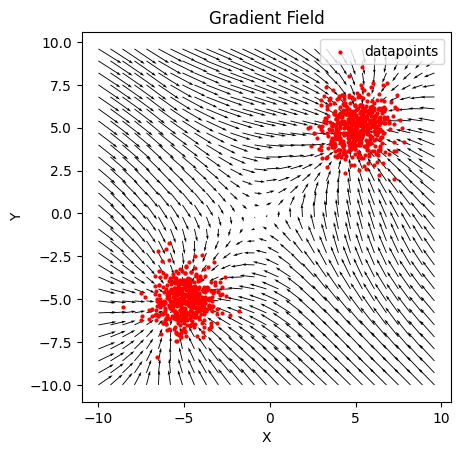

In [5]:
from score_models.utils.visualisations import plot_gradient_field
plot_gradient_field(score_model=score_model, i=L-1, datapoints=dataset[:1000])

In [6]:
from score_models.sampling import annealed_langevin_dynamics

samples = annealed_langevin_dynamics(
    score_model=score_model, 
    input_size=(500, 2), 
    sigmas=sigmas, 
    r=(-8, 8), 
).cpu().numpy()

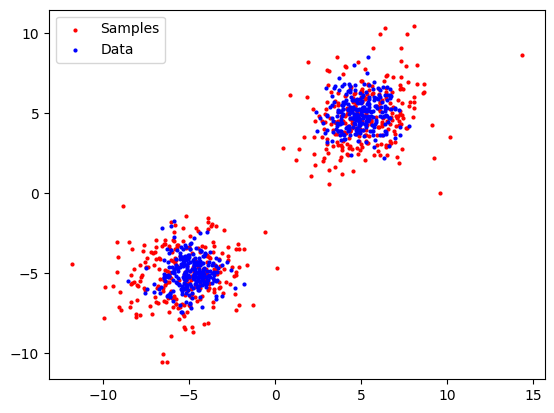

In [7]:
import matplotlib.pyplot as plt

ax = plt.gca()
ax.scatter(
    samples[:, 0], samples[:, 1], color='red', s=4, label='Samples'
)
ax.scatter(
    dataset[:500][:, 0], dataset[:500][:, 1], color='blue', s=4, label='Data'
)
plt.legend();